# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [2]:
# can comment out after executing
#!unzip processed_celeba_small.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [1]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [2]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [3]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    
    transform_train = transforms.Compose([transforms.Resize(image_size),
                                          transforms.ToTensor()])
    image_dataset = datasets.ImageFolder(root=data_dir, transform=transform_train)
    n_workers = 0
    train_loader = torch.utils.data.DataLoader(dataset=image_dataset,
                                        batch_size=batch_size,
                                        shuffle=True,
                                        num_workers=n_workers)
    
    return train_loader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [4]:
# Define function hyperparameters
batch_size = 32
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

<ipython-input-5-13b4d9c7a4be>:17: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])


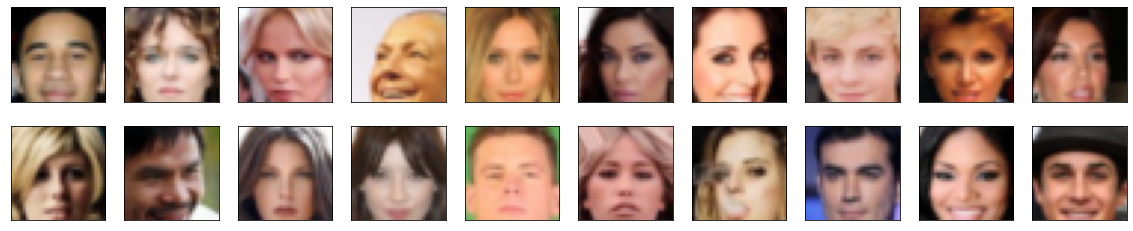

In [5]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [6]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
        
    return x*(max - min) + min


In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-1.)
Max:  tensor(0.8196)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [8]:
import torch.nn as nn
import torch.nn.functional as F

In [9]:
# helper function creating a convolutional layer
def conv(n_inputs, n_outputs, kernel_size, stride=2, padding=1, batch_norm=True):
    """Create convolutional layer with optional batch normalization."""
    layers = []
    conv_layer = nn.Conv2d(n_inputs, n_outputs, kernel_size, stride, padding, bias=False)
    
    layers.append(conv_layer)
    
    if batch_norm:
        # add batch normalization layer
        layers.append(nn.BatchNorm2d(n_outputs))
    
    return nn.Sequential(*layers)

In [59]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()
        
        self.conv_dim = conv_dim
        
        # Output_size = (Input_size - 1) * Strides + Kernel_Size - (2 *padding) + Output Padding

        # complete init function
        # 32x32x3 input of RGB image
        # no batch normalization on the first layer as it is an image
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) 
        # 16x16xconv_dim out
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        # 8x8xconv_dim*2 out
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        # 4x4xconv_dim*4 out
        # final fully connected layer with one output
        self.fc = nn.Linear(4*4*conv_dim*4, 1)
        
        self.dropout = nn.Dropout(0.2)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        # leaky Relu
        leaky_slope = 0.2
        x = F.leaky_relu(self.conv1(x), leaky_slope)
        x = F.leaky_relu(self.conv2(x), leaky_slope)
        x = F.leaky_relu(self.conv3(x), leaky_slope)
        
        x = self.dropout(x)
        
        # flatten the output into a vector to be fed into fully connected layer
        x = x.view(-1, 4*4*self.conv_dim*4)
        # final layer, no Sigmoid as it is in the loss function nn.BCEWithLogitsLoss()
        x = F.leaky_relu(self.fc(x))
                
        return x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [60]:
# helper function creating a transpose convolutional layer
def deconv(n_inputs, n_outputs, kernel_size, stride=2, padding=1, batch_norm=True):
    """Create convolutional layer with optional batch normalization."""
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(n_inputs, n_outputs, kernel_size, stride, padding, bias=False)
    
    layers.append(transpose_conv_layer)
    
    if batch_norm:
        # add batch normalization layer
        layers.append(nn.BatchNorm2d(n_outputs))
    
    return nn.Sequential(*layers)

In [61]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim # image dimension as generator output
        
        # input is a latent vector z_size
        self.fc = nn.Linear(z_size, 4*4*conv_dim*4)
        
        # transpose convolutional layers
        self.trnsp_conv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.trnsp_conv2 = deconv(conv_dim*2, conv_dim, 4)
        # no batchnormalization as output is an RGB image
        self.trnsp_conv3 = deconv(conv_dim, 3, 4, batch_norm=False)
        
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        x = F.relu(self.fc(x))
        # reshape into (batch_size, 4, 4)
        x = x.view(-1, self.conv_dim*4, 4, 4)
        # transpose convolutional layers
        x = F.relu(self.trnsp_conv1(x))
        x = self.dropout(x)
        x = F.relu(self.trnsp_conv2(x))
        x = self.dropout(x)
        # convert into -1 to 1 image
        x = F.tanh(self.trnsp_conv3(x))
                               
        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


C:\Users\dmitr\anaconda3\lib\site-packages\torch\nn\functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [62]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    mean = 0
    std_dev = 0.02
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, mean, std_dev)
    elif classname.find('BatchNorm2d') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    
    # TODO: Apply initial weights to convolutional and linear layers
        

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [63]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [64]:
# Define model hyperparams
d_conv_dim = 128
g_conv_dim = 128
z_size = 128

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=8192, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

Generator(
  (fc): Linear(in_features=128, out_features=8192, bias=True)
  (trnsp_conv1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (trnsp_conv2): Sequential(
    (0): ConvTranspose2d(256, 

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [65]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [66]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    labels = torch.ones(batch_size)*0.9 # use smoothing
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [67]:
import torch.optim as optim

learning_rate = 0.0002
beta1 = 0.5
beta2 = 0.999

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), learning_rate, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), learning_rate, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [68]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            d_optimizer.zero_grad()
            # do real images
            if train_on_gpu:
                real_images = real_images.cuda()
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)
            
            # do fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
            
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake)
            g_loss.backward()
            g_optimizer.step()
                        
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [74]:
from time import time
# set number of epochs 
n_epochs = 10


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
time_start = time()
losses = train(D, G, n_epochs=n_epochs)
print(f"Training time: {time() - time_start:.1f} seconds")

C:\Users\dmitr\anaconda3\lib\site-packages\torch\nn\functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [    1/   50] | d_loss: 1.3746 | g_loss: 0.7780
Epoch [    1/   50] | d_loss: 1.3823 | g_loss: 0.7841
Epoch [    1/   50] | d_loss: 1.3797 | g_loss: 0.7816
Epoch [    1/   50] | d_loss: 1.3799 | g_loss: 0.7840
Epoch [    1/   50] | d_loss: 1.3741 | g_loss: 0.7819
Epoch [    1/   50] | d_loss: 1.3744 | g_loss: 0.7779
Epoch [    1/   50] | d_loss: 1.3758 | g_loss: 0.7852
Epoch [    1/   50] | d_loss: 1.3738 | g_loss: 0.7775
Epoch [    1/   50] | d_loss: 1.3765 | g_loss: 0.7834
Epoch [    1/   50] | d_loss: 1.3866 | g_loss: 0.7693
Epoch [    1/   50] | d_loss: 1.3726 | g_loss: 0.7830
Epoch [    1/   50] | d_loss: 1.3800 | g_loss: 0.7852
Epoch [    1/   50] | d_loss: 1.3695 | g_loss: 0.7786
Epoch [    1/   50] | d_loss: 1.3718 | g_loss: 0.7908
Epoch [    1/   50] | d_loss: 1.3800 | g_loss: 0.7740
Epoch [    1/   50] | d_loss: 1.3806 | g_loss: 0.7847
Epoch [    1/   50] | d_loss: 1.3778 | g_loss: 0.7750
Epoch [    1/   50] | d_loss: 1.3727 | g_loss: 0.7876
Epoch [    1/   50] | d_loss

Epoch [    3/   50] | d_loss: 1.3961 | g_loss: 0.7991
Epoch [    3/   50] | d_loss: 1.3756 | g_loss: 0.7797
Epoch [    3/   50] | d_loss: 1.3778 | g_loss: 0.8023
Epoch [    3/   50] | d_loss: 1.3758 | g_loss: 0.7825
Epoch [    3/   50] | d_loss: 1.3740 | g_loss: 0.7820
Epoch [    3/   50] | d_loss: 1.3769 | g_loss: 0.7782
Epoch [    3/   50] | d_loss: 1.3820 | g_loss: 0.7763
Epoch [    3/   50] | d_loss: 1.3795 | g_loss: 0.7931
Epoch [    3/   50] | d_loss: 1.3754 | g_loss: 0.7676
Epoch [    3/   50] | d_loss: 1.3794 | g_loss: 0.7870
Epoch [    3/   50] | d_loss: 1.3773 | g_loss: 0.7748
Epoch [    3/   50] | d_loss: 1.3725 | g_loss: 0.7789
Epoch [    3/   50] | d_loss: 1.3745 | g_loss: 0.7836
Epoch [    3/   50] | d_loss: 1.3790 | g_loss: 0.7818
Epoch [    3/   50] | d_loss: 1.3747 | g_loss: 0.7935
Epoch [    3/   50] | d_loss: 1.3721 | g_loss: 0.7916
Epoch [    3/   50] | d_loss: 1.3749 | g_loss: 0.7830
Epoch [    3/   50] | d_loss: 1.3661 | g_loss: 0.7874
Epoch [    3/   50] | d_loss

Epoch [    6/   50] | d_loss: 1.3656 | g_loss: 0.7857
Epoch [    6/   50] | d_loss: 1.3621 | g_loss: 0.7945
Epoch [    6/   50] | d_loss: 1.3508 | g_loss: 0.8026
Epoch [    6/   50] | d_loss: 1.3655 | g_loss: 0.7887
Epoch [    6/   50] | d_loss: 1.3898 | g_loss: 0.7995
Epoch [    6/   50] | d_loss: 1.3675 | g_loss: 0.7658
Epoch [    6/   50] | d_loss: 1.3807 | g_loss: 0.7864
Epoch [    6/   50] | d_loss: 1.3716 | g_loss: 0.7797
Epoch [    6/   50] | d_loss: 1.3684 | g_loss: 0.7857
Epoch [    6/   50] | d_loss: 1.3748 | g_loss: 0.7812
Epoch [    6/   50] | d_loss: 1.3715 | g_loss: 0.7769
Epoch [    6/   50] | d_loss: 1.3743 | g_loss: 0.7792
Epoch [    6/   50] | d_loss: 1.3812 | g_loss: 0.7765
Epoch [    6/   50] | d_loss: 1.3698 | g_loss: 0.7831
Epoch [    6/   50] | d_loss: 1.3738 | g_loss: 0.7841
Epoch [    6/   50] | d_loss: 1.3765 | g_loss: 0.7763
Epoch [    6/   50] | d_loss: 1.3816 | g_loss: 0.7886
Epoch [    6/   50] | d_loss: 1.3755 | g_loss: 0.7709
Epoch [    6/   50] | d_loss

Epoch [    9/   50] | d_loss: 1.3820 | g_loss: 0.7739
Epoch [    9/   50] | d_loss: 1.3788 | g_loss: 0.7758
Epoch [    9/   50] | d_loss: 1.3800 | g_loss: 0.7721
Epoch [    9/   50] | d_loss: 1.3791 | g_loss: 0.7774
Epoch [    9/   50] | d_loss: 1.3803 | g_loss: 0.7777
Epoch [    9/   50] | d_loss: 1.3739 | g_loss: 0.7808
Epoch [    9/   50] | d_loss: 1.3728 | g_loss: 0.7833
Epoch [    9/   50] | d_loss: 1.3746 | g_loss: 0.7817
Epoch [    9/   50] | d_loss: 1.3802 | g_loss: 0.7741
Epoch [    9/   50] | d_loss: 1.3715 | g_loss: 0.7802
Epoch [    9/   50] | d_loss: 1.3804 | g_loss: 0.7823
Epoch [    9/   50] | d_loss: 1.3777 | g_loss: 0.7778
Epoch [    9/   50] | d_loss: 1.3787 | g_loss: 0.7819
Epoch [    9/   50] | d_loss: 1.3779 | g_loss: 0.7777
Epoch [    9/   50] | d_loss: 1.3736 | g_loss: 0.7773
Epoch [    9/   50] | d_loss: 1.3743 | g_loss: 0.7794
Epoch [    9/   50] | d_loss: 1.3764 | g_loss: 0.7777
Epoch [    9/   50] | d_loss: 1.3773 | g_loss: 0.7803
Epoch [    9/   50] | d_loss

Epoch [   11/   50] | d_loss: 1.3777 | g_loss: 0.7741
Epoch [   11/   50] | d_loss: 1.3724 | g_loss: 0.7814
Epoch [   11/   50] | d_loss: 1.3794 | g_loss: 0.7855
Epoch [   11/   50] | d_loss: 1.3775 | g_loss: 0.7840
Epoch [   11/   50] | d_loss: 1.3780 | g_loss: 0.7829
Epoch [   11/   50] | d_loss: 1.3733 | g_loss: 0.7775
Epoch [   11/   50] | d_loss: 1.3766 | g_loss: 0.7782
Epoch [   11/   50] | d_loss: 1.3776 | g_loss: 0.7768
Epoch [   11/   50] | d_loss: 1.3812 | g_loss: 0.7802
Epoch [   11/   50] | d_loss: 1.3763 | g_loss: 0.7818
Epoch [   11/   50] | d_loss: 1.3727 | g_loss: 0.7694
Epoch [   11/   50] | d_loss: 1.3783 | g_loss: 0.7904
Epoch [   11/   50] | d_loss: 1.3759 | g_loss: 0.7791
Epoch [   11/   50] | d_loss: 1.3686 | g_loss: 0.7826
Epoch [   11/   50] | d_loss: 1.3771 | g_loss: 0.7725
Epoch [   11/   50] | d_loss: 1.3743 | g_loss: 0.7706
Epoch [   11/   50] | d_loss: 1.3752 | g_loss: 0.7794
Epoch [   11/   50] | d_loss: 1.3782 | g_loss: 0.7817
Epoch [   11/   50] | d_loss

Epoch [   14/   50] | d_loss: 1.3767 | g_loss: 0.7800
Epoch [   14/   50] | d_loss: 1.3760 | g_loss: 0.7715
Epoch [   14/   50] | d_loss: 1.3780 | g_loss: 0.7805
Epoch [   14/   50] | d_loss: 1.3823 | g_loss: 0.7795
Epoch [   14/   50] | d_loss: 1.3697 | g_loss: 0.7785
Epoch [   14/   50] | d_loss: 1.3785 | g_loss: 0.7883
Epoch [   14/   50] | d_loss: 1.3664 | g_loss: 0.7854
Epoch [   14/   50] | d_loss: 1.3687 | g_loss: 0.7946
Epoch [   14/   50] | d_loss: 1.3650 | g_loss: 0.8133
Epoch [   14/   50] | d_loss: 1.3570 | g_loss: 0.7902
Epoch [   14/   50] | d_loss: 1.3600 | g_loss: 0.8005
Epoch [   14/   50] | d_loss: 1.3489 | g_loss: 0.7882
Epoch [   14/   50] | d_loss: 1.3635 | g_loss: 0.7829
Epoch [   14/   50] | d_loss: 1.3711 | g_loss: 0.7797
Epoch [   14/   50] | d_loss: 1.3701 | g_loss: 0.7888
Epoch [   14/   50] | d_loss: 1.3610 | g_loss: 0.7900
Epoch [   14/   50] | d_loss: 1.3508 | g_loss: 0.7891
Epoch [   14/   50] | d_loss: 1.3645 | g_loss: 0.7995
Epoch [   14/   50] | d_loss

Epoch [   17/   50] | d_loss: 1.3638 | g_loss: 0.8065
Epoch [   17/   50] | d_loss: 1.3500 | g_loss: 0.7946
Epoch [   17/   50] | d_loss: 1.3760 | g_loss: 0.8204
Epoch [   17/   50] | d_loss: 1.3985 | g_loss: 0.8313
Epoch [   17/   50] | d_loss: 1.3802 | g_loss: 0.7772
Epoch [   17/   50] | d_loss: 1.3900 | g_loss: 0.7846
Epoch [   17/   50] | d_loss: 1.3818 | g_loss: 0.7843
Epoch [   17/   50] | d_loss: 1.3743 | g_loss: 0.7776
Epoch [   17/   50] | d_loss: 1.3756 | g_loss: 0.7910
Epoch [   17/   50] | d_loss: 1.3827 | g_loss: 0.7883
Epoch [   17/   50] | d_loss: 1.3832 | g_loss: 0.7792
Epoch [   17/   50] | d_loss: 1.3876 | g_loss: 0.7812
Epoch [   17/   50] | d_loss: 1.3792 | g_loss: 0.7826
Epoch [   17/   50] | d_loss: 1.3754 | g_loss: 0.7861
Epoch [   17/   50] | d_loss: 1.3773 | g_loss: 0.7779
Epoch [   17/   50] | d_loss: 1.3827 | g_loss: 0.7874
Epoch [   17/   50] | d_loss: 1.3756 | g_loss: 0.7765
Epoch [   17/   50] | d_loss: 1.3826 | g_loss: 0.7703
Epoch [   17/   50] | d_loss

Epoch [   19/   50] | d_loss: 1.3601 | g_loss: 0.7916
Epoch [   19/   50] | d_loss: 1.3669 | g_loss: 0.7954
Epoch [   19/   50] | d_loss: 1.3570 | g_loss: 0.7884
Epoch [   19/   50] | d_loss: 1.3637 | g_loss: 0.8072
Epoch [   19/   50] | d_loss: 1.3629 | g_loss: 0.7991
Epoch [   19/   50] | d_loss: 1.3809 | g_loss: 0.7829
Epoch [   19/   50] | d_loss: 1.3685 | g_loss: 0.8018
Epoch [   19/   50] | d_loss: 1.3700 | g_loss: 0.7974
Epoch [   19/   50] | d_loss: 1.3615 | g_loss: 0.7914
Epoch [   19/   50] | d_loss: 1.3813 | g_loss: 0.7867
Epoch [   19/   50] | d_loss: 1.3764 | g_loss: 0.7700
Epoch [   19/   50] | d_loss: 1.3829 | g_loss: 0.7800
Epoch [   19/   50] | d_loss: 1.3815 | g_loss: 0.7786
Epoch [   19/   50] | d_loss: 1.3761 | g_loss: 0.7847
Epoch [   19/   50] | d_loss: 1.3838 | g_loss: 0.7881
Epoch [   19/   50] | d_loss: 1.3722 | g_loss: 0.7751
Epoch [   19/   50] | d_loss: 1.3789 | g_loss: 0.7723
Epoch [   19/   50] | d_loss: 1.3731 | g_loss: 0.7809
Epoch [   19/   50] | d_loss

Epoch [   22/   50] | d_loss: 1.3842 | g_loss: 0.7723
Epoch [   22/   50] | d_loss: 1.3813 | g_loss: 0.7709
Epoch [   22/   50] | d_loss: 1.3878 | g_loss: 0.7817
Epoch [   22/   50] | d_loss: 1.3861 | g_loss: 0.7809
Epoch [   22/   50] | d_loss: 1.3730 | g_loss: 0.7800
Epoch [   22/   50] | d_loss: 1.3803 | g_loss: 0.7828
Epoch [   22/   50] | d_loss: 1.3814 | g_loss: 0.7898
Epoch [   22/   50] | d_loss: 1.3798 | g_loss: 0.7989
Epoch [   22/   50] | d_loss: 1.3750 | g_loss: 0.7892
Epoch [   22/   50] | d_loss: 1.3747 | g_loss: 0.7845
Epoch [   22/   50] | d_loss: 1.3768 | g_loss: 0.7846
Epoch [   22/   50] | d_loss: 1.3752 | g_loss: 0.7809
Epoch [   22/   50] | d_loss: 1.3815 | g_loss: 0.7709
Epoch [   22/   50] | d_loss: 1.3754 | g_loss: 0.7789
Epoch [   22/   50] | d_loss: 1.3793 | g_loss: 0.7852
Epoch [   22/   50] | d_loss: 1.3761 | g_loss: 0.7781
Epoch [   22/   50] | d_loss: 1.3750 | g_loss: 0.7789
Epoch [   22/   50] | d_loss: 1.3787 | g_loss: 0.7773
Epoch [   22/   50] | d_loss

Epoch [   25/   50] | d_loss: 1.3776 | g_loss: 0.7793
Epoch [   25/   50] | d_loss: 1.3769 | g_loss: 0.7802
Epoch [   25/   50] | d_loss: 1.3728 | g_loss: 0.7931
Epoch [   25/   50] | d_loss: 1.3727 | g_loss: 0.7790
Epoch [   25/   50] | d_loss: 1.3718 | g_loss: 0.7918
Epoch [   25/   50] | d_loss: 1.3729 | g_loss: 0.7805
Epoch [   25/   50] | d_loss: 1.3737 | g_loss: 0.7887
Epoch [   25/   50] | d_loss: 1.3763 | g_loss: 0.7925
Epoch [   25/   50] | d_loss: 1.3743 | g_loss: 0.7964
Epoch [   25/   50] | d_loss: 1.3779 | g_loss: 0.7871
Epoch [   25/   50] | d_loss: 1.3744 | g_loss: 0.7864
Epoch [   25/   50] | d_loss: 1.3696 | g_loss: 0.7939
Epoch [   25/   50] | d_loss: 1.3611 | g_loss: 0.8029
Epoch [   25/   50] | d_loss: 1.3546 | g_loss: 0.8249
Epoch [   25/   50] | d_loss: 1.3821 | g_loss: 0.8041
Epoch [   25/   50] | d_loss: 1.3865 | g_loss: 0.7666
Epoch [   25/   50] | d_loss: 1.3705 | g_loss: 0.7963
Epoch [   25/   50] | d_loss: 1.3614 | g_loss: 0.7954
Epoch [   25/   50] | d_loss

Epoch [   27/   50] | d_loss: 1.3711 | g_loss: 0.7906
Epoch [   27/   50] | d_loss: 1.3724 | g_loss: 0.7904
Epoch [   27/   50] | d_loss: 1.3725 | g_loss: 0.7922
Epoch [   27/   50] | d_loss: 1.3687 | g_loss: 0.7877
Epoch [   27/   50] | d_loss: 1.3728 | g_loss: 0.8008
Epoch [   27/   50] | d_loss: 1.3606 | g_loss: 0.7966
Epoch [   27/   50] | d_loss: 1.3591 | g_loss: 0.7969
Epoch [   27/   50] | d_loss: 1.3575 | g_loss: 0.7916
Epoch [   27/   50] | d_loss: 1.3783 | g_loss: 0.7905
Epoch [   27/   50] | d_loss: 1.3725 | g_loss: 0.7955
Epoch [   27/   50] | d_loss: 1.3482 | g_loss: 0.8104
Epoch [   27/   50] | d_loss: 1.4022 | g_loss: 0.7931
Epoch [   27/   50] | d_loss: 1.3713 | g_loss: 0.7782
Epoch [   27/   50] | d_loss: 1.3742 | g_loss: 0.7819
Epoch [   27/   50] | d_loss: 1.3797 | g_loss: 0.7801
Epoch [   27/   50] | d_loss: 1.3754 | g_loss: 0.7895
Epoch [   27/   50] | d_loss: 1.3798 | g_loss: 0.7794
Epoch [   27/   50] | d_loss: 1.3750 | g_loss: 0.7927
Epoch [   27/   50] | d_loss

Epoch [   30/   50] | d_loss: 1.3769 | g_loss: 0.7786
Epoch [   30/   50] | d_loss: 1.3772 | g_loss: 0.7823
Epoch [   30/   50] | d_loss: 1.3772 | g_loss: 0.7857
Epoch [   30/   50] | d_loss: 1.3741 | g_loss: 0.7748
Epoch [   30/   50] | d_loss: 1.3805 | g_loss: 0.7800
Epoch [   30/   50] | d_loss: 1.3702 | g_loss: 0.7890
Epoch [   30/   50] | d_loss: 1.3851 | g_loss: 0.7747
Epoch [   30/   50] | d_loss: 1.3733 | g_loss: 0.7808
Epoch [   30/   50] | d_loss: 1.3700 | g_loss: 0.7817
Epoch [   30/   50] | d_loss: 1.3704 | g_loss: 0.7874
Epoch [   30/   50] | d_loss: 1.3779 | g_loss: 0.7819
Epoch [   30/   50] | d_loss: 1.3761 | g_loss: 0.7844
Epoch [   30/   50] | d_loss: 1.3783 | g_loss: 0.7938
Epoch [   30/   50] | d_loss: 1.3760 | g_loss: 0.7847
Epoch [   30/   50] | d_loss: 1.3691 | g_loss: 0.7851
Epoch [   30/   50] | d_loss: 1.3644 | g_loss: 0.8146
Epoch [   30/   50] | d_loss: 1.3563 | g_loss: 0.8159
Epoch [   30/   50] | d_loss: 1.3873 | g_loss: 0.7859
Epoch [   30/   50] | d_loss

Epoch [   33/   50] | d_loss: 1.3714 | g_loss: 0.7876
Epoch [   33/   50] | d_loss: 1.3679 | g_loss: 0.7827
Epoch [   33/   50] | d_loss: 1.3722 | g_loss: 0.7925
Epoch [   33/   50] | d_loss: 1.3651 | g_loss: 0.8011
Epoch [   33/   50] | d_loss: 1.3697 | g_loss: 0.7882
Epoch [   33/   50] | d_loss: 1.3753 | g_loss: 0.7946
Epoch [   33/   50] | d_loss: 1.3516 | g_loss: 0.8044
Epoch [   33/   50] | d_loss: 1.3623 | g_loss: 0.8117
Epoch [   33/   50] | d_loss: 1.3593 | g_loss: 0.7967
Epoch [   33/   50] | d_loss: 1.3544 | g_loss: 0.7812
Epoch [   33/   50] | d_loss: 1.3361 | g_loss: 0.7493
Epoch [   33/   50] | d_loss: 1.3871 | g_loss: 0.7792
Epoch [   33/   50] | d_loss: 1.3669 | g_loss: 0.7778
Epoch [   33/   50] | d_loss: 1.3793 | g_loss: 0.7778
Epoch [   33/   50] | d_loss: 1.3775 | g_loss: 0.7945
Epoch [   33/   50] | d_loss: 1.3735 | g_loss: 0.7857
Epoch [   33/   50] | d_loss: 1.3717 | g_loss: 0.7941
Epoch [   33/   50] | d_loss: 1.3751 | g_loss: 0.7871
Epoch [   33/   50] | d_loss

Epoch [   35/   50] | d_loss: 1.3593 | g_loss: 0.8066
Epoch [   35/   50] | d_loss: 1.3622 | g_loss: 0.8038
Epoch [   35/   50] | d_loss: 1.3757 | g_loss: 0.8095
Epoch [   35/   50] | d_loss: 1.3775 | g_loss: 0.7902
Epoch [   35/   50] | d_loss: 1.3711 | g_loss: 0.7798
Epoch [   35/   50] | d_loss: 1.3689 | g_loss: 0.7985
Epoch [   35/   50] | d_loss: 1.3607 | g_loss: 0.8038
Epoch [   35/   50] | d_loss: 1.3502 | g_loss: 0.8096
Epoch [   35/   50] | d_loss: 1.3488 | g_loss: 0.8107
Epoch [   35/   50] | d_loss: 1.3565 | g_loss: 0.8124
Epoch [   35/   50] | d_loss: 1.3810 | g_loss: 0.7729
Epoch [   35/   50] | d_loss: 1.3866 | g_loss: 0.7774
Epoch [   35/   50] | d_loss: 1.3749 | g_loss: 0.7875
Epoch [   35/   50] | d_loss: 1.3694 | g_loss: 0.7959
Epoch [   35/   50] | d_loss: 1.3706 | g_loss: 0.7803
Epoch [   35/   50] | d_loss: 1.3645 | g_loss: 0.7873
Epoch [   35/   50] | d_loss: 1.3872 | g_loss: 0.8242
Epoch [   35/   50] | d_loss: 1.3775 | g_loss: 0.7814
Epoch [   35/   50] | d_loss

Epoch [   38/   50] | d_loss: 1.3801 | g_loss: 0.7827
Epoch [   38/   50] | d_loss: 1.3713 | g_loss: 0.7928
Epoch [   38/   50] | d_loss: 1.3735 | g_loss: 0.7851
Epoch [   38/   50] | d_loss: 1.3648 | g_loss: 0.7854
Epoch [   38/   50] | d_loss: 1.3719 | g_loss: 0.7833
Epoch [   38/   50] | d_loss: 1.3682 | g_loss: 0.7852
Epoch [   38/   50] | d_loss: 1.3734 | g_loss: 0.8020
Epoch [   38/   50] | d_loss: 1.3546 | g_loss: 0.7945
Epoch [   38/   50] | d_loss: 1.3808 | g_loss: 0.7648
Epoch [   38/   50] | d_loss: 1.3655 | g_loss: 0.8100
Epoch [   38/   50] | d_loss: 1.3639 | g_loss: 0.8068
Epoch [   38/   50] | d_loss: 1.3896 | g_loss: 0.7954
Epoch [   38/   50] | d_loss: 1.3581 | g_loss: 0.8153
Epoch [   38/   50] | d_loss: 1.3776 | g_loss: 0.8275
Epoch [   38/   50] | d_loss: 1.3491 | g_loss: 0.8204
Epoch [   38/   50] | d_loss: 1.3508 | g_loss: 0.8128
Epoch [   38/   50] | d_loss: 1.3875 | g_loss: 0.7847
Epoch [   38/   50] | d_loss: 1.3757 | g_loss: 0.7747
Epoch [   38/   50] | d_loss

Epoch [   41/   50] | d_loss: 1.3443 | g_loss: 0.8144
Epoch [   41/   50] | d_loss: 1.4316 | g_loss: 0.8171
Epoch [   41/   50] | d_loss: 1.3833 | g_loss: 0.7733
Epoch [   41/   50] | d_loss: 1.3616 | g_loss: 0.7974
Epoch [   41/   50] | d_loss: 1.3834 | g_loss: 0.8329
Epoch [   41/   50] | d_loss: 1.3702 | g_loss: 0.8078
Epoch [   41/   50] | d_loss: 1.3744 | g_loss: 0.8198
Epoch [   41/   50] | d_loss: 1.3601 | g_loss: 0.8386
Epoch [   41/   50] | d_loss: 1.3846 | g_loss: 0.7967
Epoch [   41/   50] | d_loss: 1.3768 | g_loss: 0.8232
Epoch [   41/   50] | d_loss: 1.3578 | g_loss: 0.7709
Epoch [   41/   50] | d_loss: 1.3954 | g_loss: 0.7902
Epoch [   41/   50] | d_loss: 1.3810 | g_loss: 0.7934
Epoch [   41/   50] | d_loss: 1.3699 | g_loss: 0.7976
Epoch [   41/   50] | d_loss: 1.3720 | g_loss: 0.7910
Epoch [   41/   50] | d_loss: 1.3773 | g_loss: 0.7976
Epoch [   41/   50] | d_loss: 1.3672 | g_loss: 0.7985
Epoch [   41/   50] | d_loss: 1.3722 | g_loss: 0.7949
Epoch [   41/   50] | d_loss

Epoch [   43/   50] | d_loss: 1.3719 | g_loss: 0.8053
Epoch [   43/   50] | d_loss: 1.3835 | g_loss: 0.7926
Epoch [   43/   50] | d_loss: 1.3700 | g_loss: 0.8288
Epoch [   43/   50] | d_loss: 1.3618 | g_loss: 0.8259
Epoch [   43/   50] | d_loss: 1.3557 | g_loss: 0.8127
Epoch [   43/   50] | d_loss: 1.3818 | g_loss: 0.7884
Epoch [   43/   50] | d_loss: 1.3725 | g_loss: 0.7856
Epoch [   43/   50] | d_loss: 1.3619 | g_loss: 0.7978
Epoch [   43/   50] | d_loss: 1.3717 | g_loss: 0.8037
Epoch [   43/   50] | d_loss: 1.3623 | g_loss: 0.8160
Epoch [   43/   50] | d_loss: 1.3585 | g_loss: 0.8383
Epoch [   43/   50] | d_loss: 1.3497 | g_loss: 0.8006
Epoch [   43/   50] | d_loss: 1.3504 | g_loss: 0.7993
Epoch [   43/   50] | d_loss: 1.3432 | g_loss: 0.8062
Epoch [   43/   50] | d_loss: 1.3642 | g_loss: 0.7843
Epoch [   43/   50] | d_loss: 1.3589 | g_loss: 0.8058
Epoch [   43/   50] | d_loss: 1.3424 | g_loss: 0.8232
Epoch [   43/   50] | d_loss: 1.3636 | g_loss: 0.8083
Epoch [   43/   50] | d_loss

Epoch [   46/   50] | d_loss: 1.3783 | g_loss: 0.7880
Epoch [   46/   50] | d_loss: 1.3696 | g_loss: 0.8066
Epoch [   46/   50] | d_loss: 1.3760 | g_loss: 0.8239
Epoch [   46/   50] | d_loss: 1.3626 | g_loss: 0.8276
Epoch [   46/   50] | d_loss: 1.3471 | g_loss: 0.8074
Epoch [   46/   50] | d_loss: 1.3506 | g_loss: 0.8222
Epoch [   46/   50] | d_loss: 1.3507 | g_loss: 0.8125
Epoch [   46/   50] | d_loss: 1.3842 | g_loss: 0.8007
Epoch [   46/   50] | d_loss: 1.3696 | g_loss: 0.7705
Epoch [   46/   50] | d_loss: 1.3750 | g_loss: 0.7762
Epoch [   46/   50] | d_loss: 1.3737 | g_loss: 0.7894
Epoch [   46/   50] | d_loss: 1.3683 | g_loss: 0.8006
Epoch [   46/   50] | d_loss: 1.3600 | g_loss: 0.7949
Epoch [   46/   50] | d_loss: 1.3741 | g_loss: 0.8683
Epoch [   46/   50] | d_loss: 1.3750 | g_loss: 0.7994
Epoch [   46/   50] | d_loss: 1.3708 | g_loss: 0.7908
Epoch [   46/   50] | d_loss: 1.3617 | g_loss: 0.8173
Epoch [   46/   50] | d_loss: 1.3700 | g_loss: 0.8028
Epoch [   46/   50] | d_loss

Epoch [   49/   50] | d_loss: 1.3719 | g_loss: 0.7934
Epoch [   49/   50] | d_loss: 1.3681 | g_loss: 0.7929
Epoch [   49/   50] | d_loss: 1.3668 | g_loss: 0.8240
Epoch [   49/   50] | d_loss: 1.3602 | g_loss: 0.8099
Epoch [   49/   50] | d_loss: 1.3673 | g_loss: 0.8050
Epoch [   49/   50] | d_loss: 1.3401 | g_loss: 0.8157
Epoch [   49/   50] | d_loss: 1.3716 | g_loss: 0.8163
Epoch [   49/   50] | d_loss: 1.3795 | g_loss: 0.7949
Epoch [   49/   50] | d_loss: 1.3679 | g_loss: 0.8566
Epoch [   49/   50] | d_loss: 1.3318 | g_loss: 0.8226
Epoch [   49/   50] | d_loss: 1.3450 | g_loss: 0.8232
Epoch [   49/   50] | d_loss: 1.3441 | g_loss: 0.8158
Epoch [   49/   50] | d_loss: 1.3700 | g_loss: 0.7992
Epoch [   49/   50] | d_loss: 1.3552 | g_loss: 0.8377
Epoch [   49/   50] | d_loss: 1.3498 | g_loss: 0.8309
Epoch [   49/   50] | d_loss: 1.3743 | g_loss: 0.8276
Epoch [   49/   50] | d_loss: 1.3687 | g_loss: 0.8153
Epoch [   49/   50] | d_loss: 1.3183 | g_loss: 0.7687
Epoch [   49/   50] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

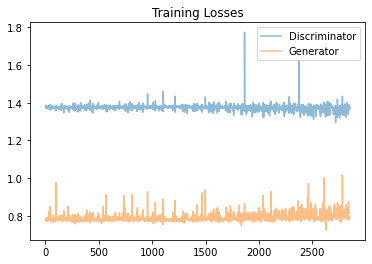

In [75]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [76]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [77]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

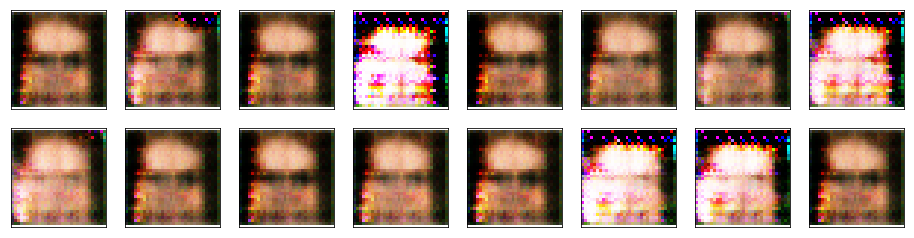

In [144]:
# epoch=1, lr=0.001, dim=512, z=128, batch=32
#_ = view_samples(-1, samples)

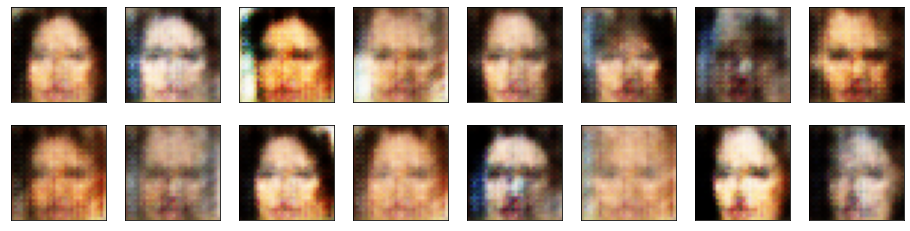

In [27]:
# epoch=1, lr=0.001, dim=128, z=128, batch=32
#_ = view_samples(-1, samples)

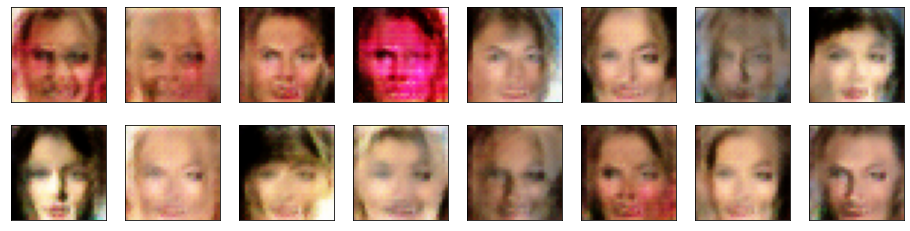

In [33]:
# epoch=10, lr=0.001, dim=128, z=128, batch=32 t=1710 seconds 
#_ = view_samples(-1, samples)

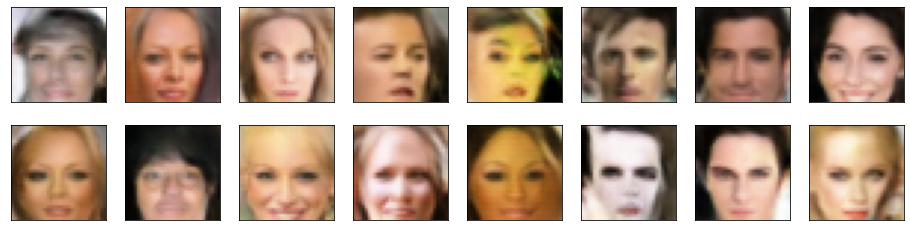

In [38]:
# epoch=50, lr=0.001, dim=128, z=128, batch=32, training time 1.5h
#_ = view_samples(-1, samples)

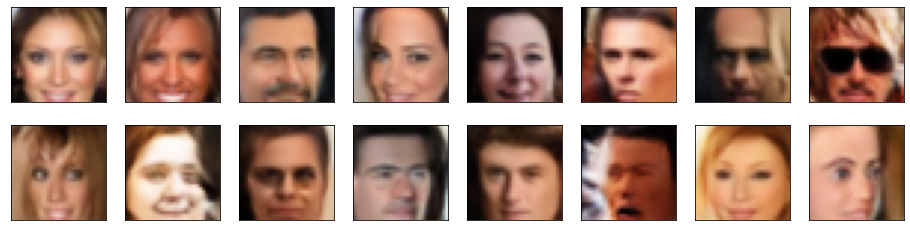

In [45]:
# decreasing learning rate
# epoch=10, lr=0.0002, dim=128, z=128, batch=32 t=1713 seconds 
#_ = view_samples(-1, samples)

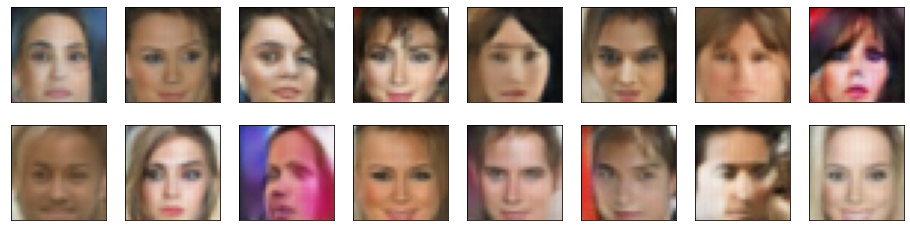

In [28]:
# decreasing learning rate, increase number of epochs
# epoch=50, lr=0.0002, dim=128, z=128, batch=32
#_ = view_samples(-1, samples)

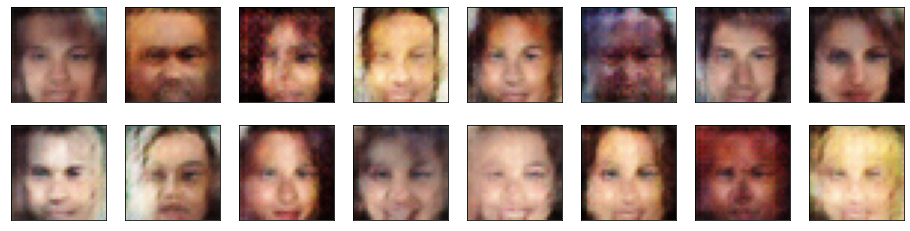

In [43]:
# dropout after each convolutional layer in discriminator
# epoch=10, lr=0.0002, dim=128, z=128, batch=32 t=1715 seconds
#_ = view_samples(-1, samples)

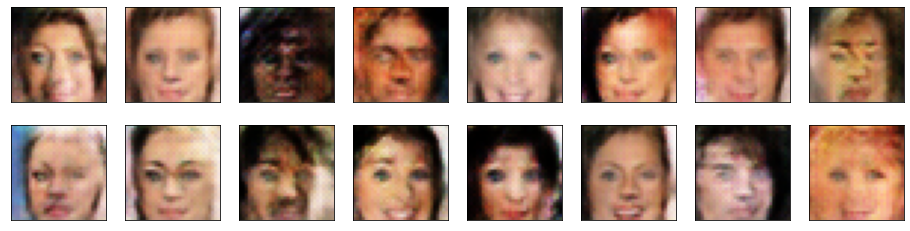

In [58]:
# no dropout after each convolutional layer in discriminator
# epoch=10, lr=0.0002, dim=128, z=128, batch=32 t=1715 seconds
#_ = view_samples(-1, samples)

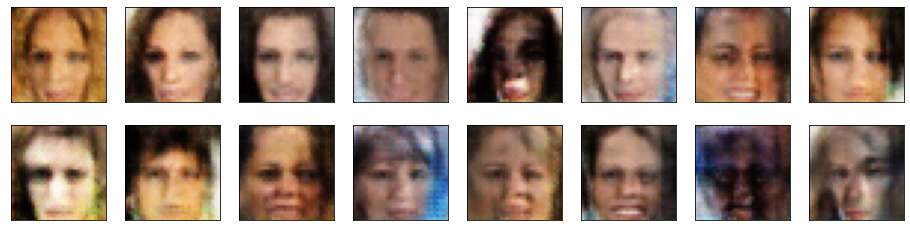

In [73]:
# decreasing learning rate
# epoch=10, lr=0.0002, dim=128, z=128, batch=32 t=1703 seconds 
#_ = view_samples(-1, samples)

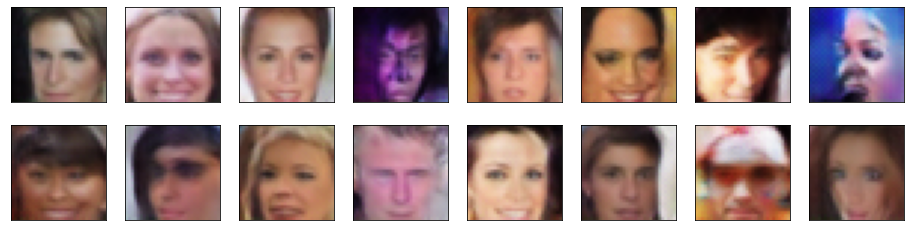

In [78]:
# epoch=50, lr=0.0002, dim=128, z=128, batch=32 t=8531 seconds 
#_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** (Write your answer in this cell)
learning rate at 0.0002 produced uniform grey images

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.